In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r"Desktop\PGP-DSE Data\Machine Learning\Time Series Dataset\Monthly Beer Production\data.csv")
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [3]:
df.shape

(476, 2)

In [4]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARMA, ARIMA
from sklearn.metrics import explained_variance_score

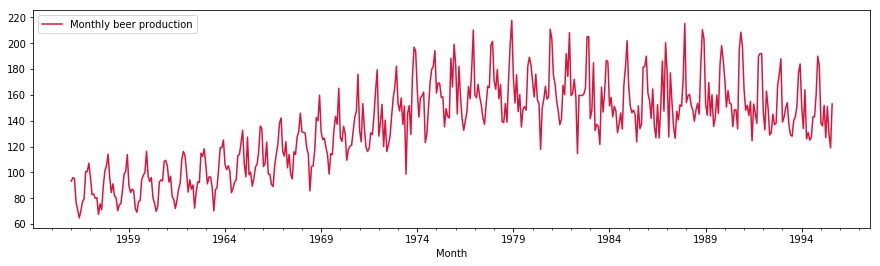

In [5]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
# plt.figure(figsize=(15,4))
df.plot(kind='line',color='crimson',figsize=(15,4))

In [6]:
# By looking at this plot, we can say that there is definitely some seasonlity in the data and trend is somewhat increasing
# in nature, or we could say that it is going up and becoming somewhat stable.
# Let's look at each of the Time Series Component separately to have a better understanding.

Text(0.5,0,'')

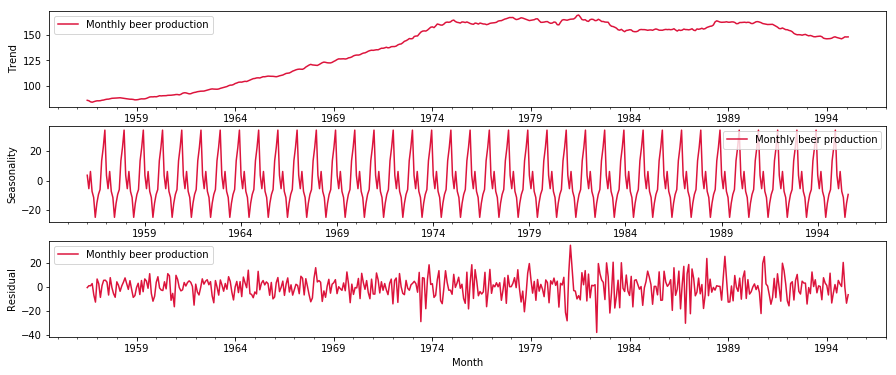

In [7]:
res = sm.tsa.seasonal_decompose(df,model='additive')
# resplot = res.plot()
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,6))
res.trend.plot(ax=ax1,color='crimson')
ax1.set_ylabel("Trend")
ax1.set_xlabel("")
res.seasonal.plot(ax=ax2,color='crimson')
ax2.set_ylabel("Seasonality")
ax1.set_xlabel("")
res.resid.plot(ax=ax3,color='crimson')
ax3.set_ylabel("Residual")
ax1.set_xlabel("")

In [8]:
# So, as we inferred, there is a strong yearly seasonality in the data and trend says that the production is increasing till
# 1975, after that it is following a somewhat stable yearly Beer Production.

In [9]:
# Most of the Time Series models work on the assumption that. Moreover, contrary theories related to Stationary Time Series
# are easier to implement than Non-Stationary Time Series theories.
# A time Series object is stationary if it has the following properties:-
# 1. No Trend Exists
# 2. Mean remains constant over time
# 3. Variance remains constant over time
# 4. No Auto-Correlation exists

In [10]:
# Now that we know the properties of a time series for it to be stationary, now we can look at the techniques to test if a
# time series is stationary or not. To check that we can do 2 things:-
# 1. Exploratory data Analysis
# 2. Dickey-Fuller Test

In [11]:
# In Exploratory Data Analysis, we will try to look at the Rolling_Mean & Rolling_Variance to check for the Stationarity of
# the Time Series at hand.
# If these rolling metrics remains constant over time, we will be able to conclude that this Time Series is Stationary, else
# we will have to make the Time Series Stationary.

In [12]:
def evaluate_stationarity(timeseries,t):
    rolmean = timeseries.rolling(window=t).mean()
    rolstd = timeseries.rolling(window=t).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(15,4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

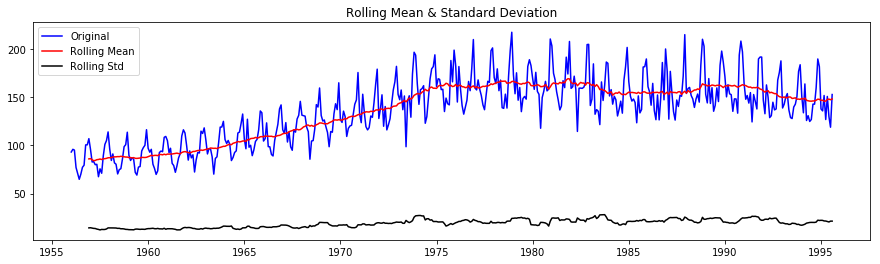

Results of Dickey-Fuller Test:
Test Statistic                  -2.282661
p-value                          0.177621
#Lags Used                      17.000000
Number of Observations Used    458.000000
Critical Value (1%)             -3.444709
Critical Value (5%)             -2.867871
Critical Value (10%)            -2.570142
dtype: float64


In [13]:
evaluate_stationarity(df['Monthly beer production'],12)

In [14]:
# From the above plot we could say that the Time Series is not Stationary, hence, now the path for making forecasts would
# not be straight forward. Now, we first have to make the Time Series Stationary then only we will be able to move forward
# towards making forecasts.
# There are several techniques to make Time Series Stationary:-
# 1. Applying Transformations 
# 2. Estimating Trend and removing it from the original series
# 3. Differencing
# 4. Decomposition

# We will try to implement all of them one by one and check if any of these helps in making Time Series Stationary

# Applying Transformations

Log Transformation

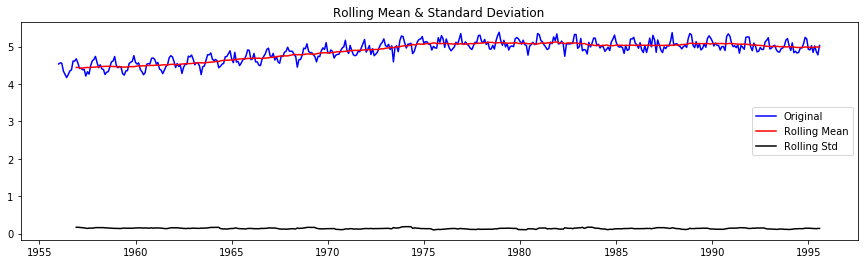

Results of Dickey-Fuller Test:
Test Statistic                  -2.800769
p-value                          0.058164
#Lags Used                      17.000000
Number of Observations Used    458.000000
Critical Value (1%)             -3.444709
Critical Value (5%)             -2.867871
Critical Value (10%)            -2.570142
dtype: float64


In [15]:
df_log = np.log(df['Monthly beer production'])
evaluate_stationarity(df_log,12)

Square Root Transformation

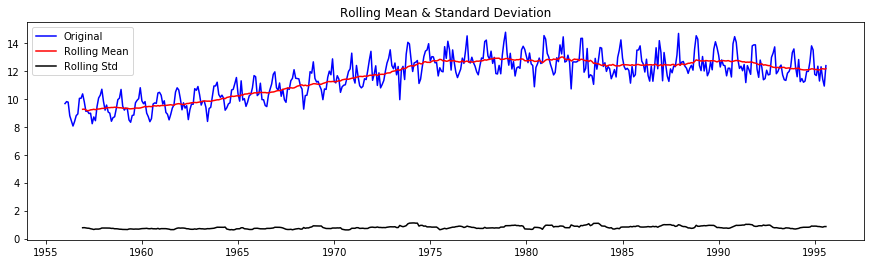

Results of Dickey-Fuller Test:
Test Statistic                  -2.525402
p-value                          0.109415
#Lags Used                      17.000000
Number of Observations Used    458.000000
Critical Value (1%)             -3.444709
Critical Value (5%)             -2.867871
Critical Value (10%)            -2.570142
dtype: float64


In [16]:
df_sqrt = np.sqrt(df['Monthly beer production'])
evaluate_stationarity(df_sqrt,12)

Cube Root Transformation

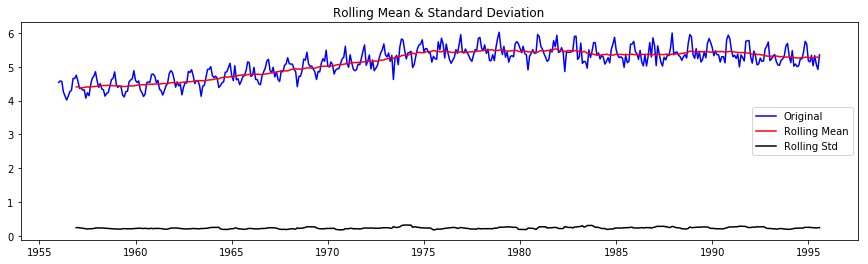

Results of Dickey-Fuller Test:
Test Statistic                  -2.613914
p-value                          0.090156
#Lags Used                      17.000000
Number of Observations Used    458.000000
Critical Value (1%)             -3.444709
Critical Value (5%)             -2.867871
Critical Value (10%)            -2.570142
dtype: float64


In [17]:
df_cbrt = np.cbrt(df['Monthly beer production'])
evaluate_stationarity(df_cbrt,12)

In [18]:
# The Rolling_Mean and Rolling_Variance does not seem to be constant throughout the time period, and the same is reflected
# in the Dickey-Fuller Test where the test statistic is greater than the critical value, which means that the Time Series
# is Non-Stationary in nature.

# Estimating Trend and removing it from the original series

The approach has 2 folds: at first we need to estimate the trend and secondly remove it from the Time Series object.

Techniques for estimating Trend are:-
1. Moving Average Smoothing
2. Exponentially Weighted Moving Average

In [19]:
# Moving Average Smoothing
# Moving Average Smoothing is similar to Rolling_Mean in that in both these methods, the average of observations lying in a
# fixed window size is calculated in order to estimate the observation at a given time.

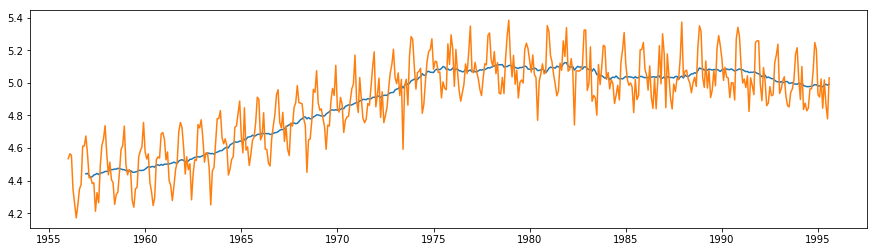

In [20]:
moving_avg = df_log.rolling(12).mean()
plt.figure(figsize=(15,4))
plt.plot(moving_avg)
plt.plot(df_log)

In [21]:
df_log_moving_avg_diff = df_log - moving_avg
df_log_moving_avg_diff.head(15)

Month
1956-01-01         NaN
1956-02-01         NaN
1956-03-01         NaN
1956-04-01         NaN
1956-05-01         NaN
1956-06-01         NaN
1956-07-01         NaN
1956-08-01         NaN
1956-09-01         NaN
1956-10-01         NaN
1956-11-01         NaN
1956-12-01    0.231830
1957-01-01    0.118994
1957-02-01   -0.015558
1957-03-01    0.001590
Name: Monthly beer production, dtype: float64

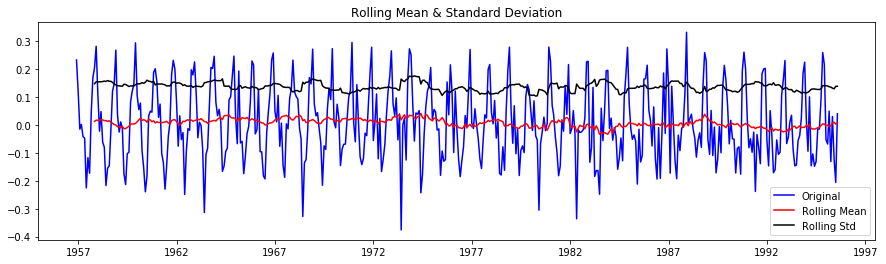

Results of Dickey-Fuller Test:
Test Statistic                  -3.432559
p-value                          0.009898
#Lags Used                      13.000000
Number of Observations Used    451.000000
Critical Value (1%)             -3.444933
Critical Value (5%)             -2.867970
Critical Value (10%)            -2.570195
dtype: float64


In [22]:
df_log_moving_avg_diff.dropna(inplace=True)
evaluate_stationarity(df_log_moving_avg_diff,12)

In [23]:
# Well now we have some concrete results, now our Time Series object is Stationary.
# We have achieved Stationarity in our Time Series object, however, we want to check if other techniques can make it closer
# to the Stationary nature.

In [24]:
# Exponentially Weighted Moving Average
# Exponentially weighted moving average is similar to the rolling mean approach except that a recent observation is assigned
# the highest weight and a distinct one the lowest. In other words, the weight assignment decreases exponentially from 
# the most recent observation to the most distinct one.

# Differencing

In [25]:
# Differencing subtracts the time series from a lagged version of itself.Differencing stabilizes the mean of a time series
# by removing changes in the level.
# Differencing in our situation would be more effective in making time series object stationary

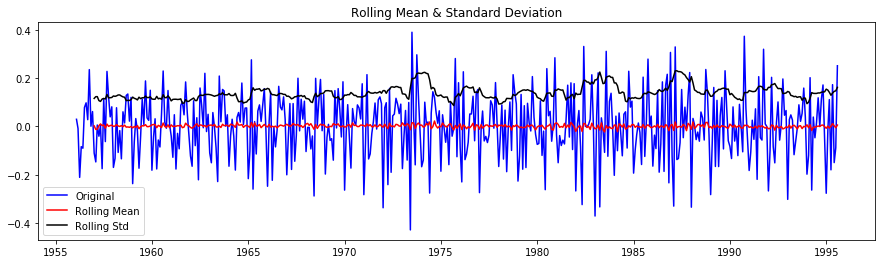

Results of Dickey-Fuller Test:
Test Statistic                  -4.869646
p-value                          0.000040
#Lags Used                      18.000000
Number of Observations Used    456.000000
Critical Value (1%)             -3.444772
Critical Value (5%)             -2.867899
Critical Value (10%)            -2.570157
dtype: float64


In [26]:
df_log_diff = df_log - df_log.shift()
df_log_diff.dropna(inplace=True)
evaluate_stationarity(df_log_diff,12)

In [27]:
# This is a remarkable improvement, now Rolling_Mean and Rolling_Variance are almost constant.
# The same has been reflected in the Dickey-Fuller Test, as the test statistic is much smaller than the critcal values.
# We can also go ahead and check 2nd and 3rd order differencing and see if we are able to make Time Series object closer to
# stationarity.

# Decomposition

In [28]:
# This is yet another approach for making Time Series object stationary, here we will be looking at each of the Time Series
# components individually and remove Trend and Seasonality out of the equation and check Rolling_Mean and Rolling_Variance
# for residual.

Text(0.5,0,'')

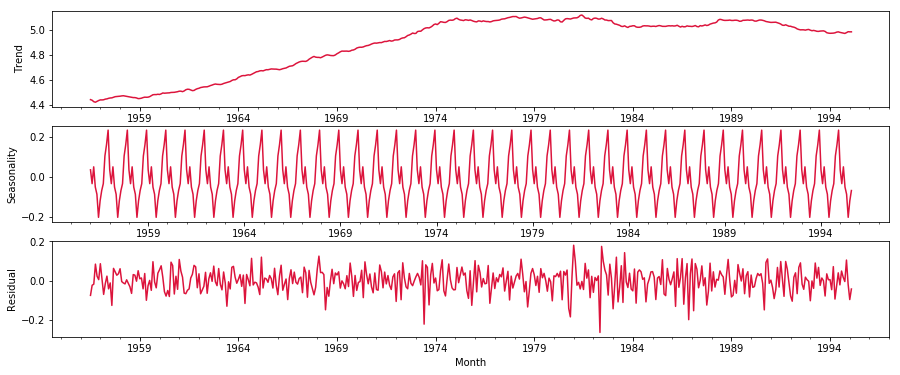

In [29]:
res = sm.tsa.seasonal_decompose(df_log,model='additive')
# resplot = res.plot()
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,6))
res.trend.plot(ax=ax1,color='crimson')
ax1.set_ylabel("Trend")
ax1.set_xlabel("")
res.seasonal.plot(ax=ax2,color='crimson')
ax2.set_ylabel("Seasonality")
ax1.set_xlabel("")
res.resid.plot(ax=ax3,color='crimson')
ax3.set_ylabel("Residual")
ax1.set_xlabel("")

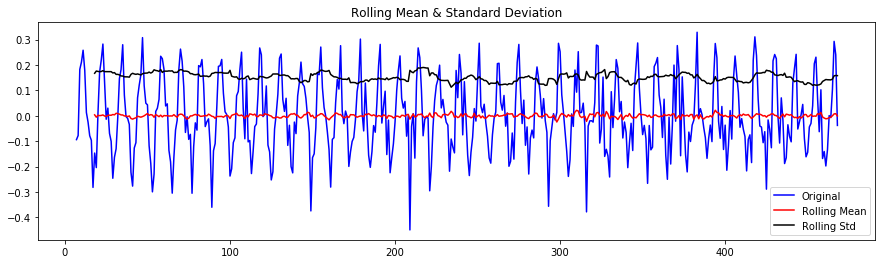

Results of Dickey-Fuller Test:
Test Statistic                -1.063198e+01
p-value                        5.186305e-19
#Lags Used                     1.500000e+01
Number of Observations Used    4.460000e+02
Critical Value (1%)           -3.445097e+00
Critical Value (5%)           -2.868042e+00
Critical Value (10%)          -2.570233e+00
dtype: float64


In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(list(df_log), freq=15)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

df_log_decompose = pd.Series(residual)
df_log_decompose.dropna(inplace=True)
evaluate_stationarity(df_log_decompose,12)

In [31]:
# By just looking at p-value, we can say that the results are very much significant, however, if we look at the test stats
# that is not much less as compared to the differencing we performed earlier.
# By now we have dealt with the first 3 conditions of a Time Series object to be stationary, and now the 4th condition i.e.
# to check if our data has Auto-Correlation.
# If Auto-Correlation varies over time for the Time Series object, then we would have to figure the techniques to make the
# Auto-Correlations constant.

# Checking Auto-Correlation

Auto-Correlation is the correlation between the series at current time with a lagged version of itself. Auto-Correlation exists in 2 variants and those are:-

1. Auto-Correlation Function (ACF)

    --> It determines the correlation of time series along with a lagged version of itself


2. Partial Auto-Correlation Function (PACF)

    --> It also measures the correlation of time series with a lagged version of itself except that it eliminates the variations already explained by the prior comparisons. For example lag of 5, it will remove the variations already captured between t0 and t3

In [32]:
# Measuring Auto-Correlation
# There is a statistical technique to measure Auto-Correlation within the time series and that is:- Durbin Watson Statistic

# Durbin-Watson Statistic
# Contrary to the correlation correlogram, Durbin-Watson is more of a statistical approach to determining the existence of
# Auto-Correlation within the data. It does so by computing Auto-Correlation among residuals from a statistical regression
# analysis. It returns a number between 0 & 4, where:
# 0 --> Depicts Strong Positive Correlation
# 2 --> Depicts no correlation at all
# 4 --> Depicts Strong negative Correlation

# On doing some research I found that differening is capable of eradicating ACF and PACF. Having applied differencing we are
# expecting no presence of ACF and PACF.

# At first, we will try to check the presence of Auto-Correlation using Durbin-Watson statistics method.

In [33]:
# Calculating Durbin-Watson Test Statistic
test_stat = sm.stats.durbin_watson(df_log_diff)
test_stat

2.4365206354965094

In [34]:
# Hooray, we can see that the results are approaching close to 2, which means that the log-transformaed Time Series object
# does not have Auto-Correlation.

# Let's verify the same by plotting ACF nad PACF correlograms on Log-Transformed Differencing Time Series object

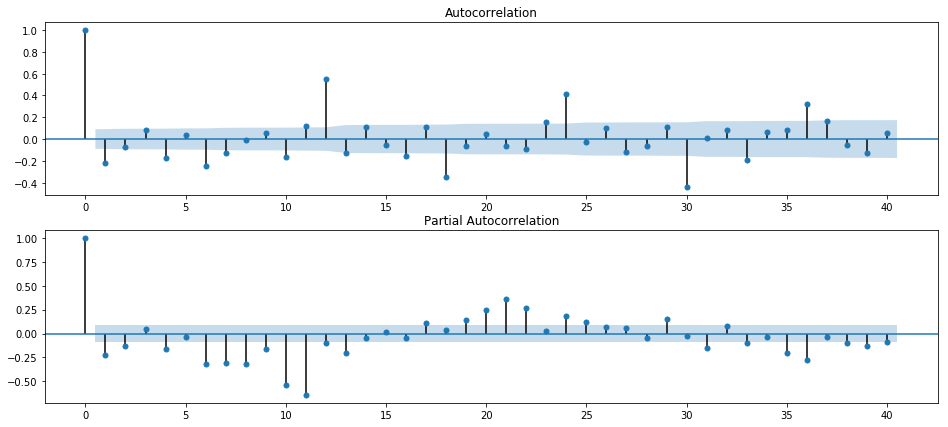

In [35]:
import warnings
warnings.filterwarnings("ignore")
f, axes = plt.subplots(2, 1, figsize=(16,7))

fig = sm.graphics.tsa.plot_acf(df_log_diff.squeeze(), lags=40, ax=axes[0])

fig = sm.graphics.tsa.plot_pacf(df_log_diff, lags=40, ax=axes[1])

# Implementing ARIMA

In [36]:
from sklearn.metrics import mean_squared_error
X = df_log.values
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(X)]


def ARIMA_FUNCTION(p,q):
    for t in range(len(test)):
        model_1 = ARIMA(history, order=(p,1,q))
        model_fit_1 = model_1.fit(disp=0)
        output = model_fit_1.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    return mean_squared_error(test, predictions)**0.5

In [37]:
results=[]
for i in range(3):
    for j in range(4):
        if (i>j or i==0) and (i-j<3) :
            predictions = list()
            history = [x for x in train]
            results.append([i,j,ARIMA_FUNCTION(i,j)])
print(results)

[[0, 0, 0.1399393980081307], [0, 1, 0.1364156884761719], [0, 2, 0.12223215739541012], [0, 3, 0.12553299478323196], [1, 0, 0.13868139964738166], [2, 0, 0.13503124386306561], [2, 1, 0.1245078763985325]]


In [38]:
model = ARIMA(train, order=(0,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  427
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 285.100
Method:                       css-mle   S.D. of innovations              0.124
Date:                Sat, 05 Sep 2020   AIC                           -562.200
Time:                        16:35:26   BIC                           -545.972
Sample:                             1   HQIC                          -555.790
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.964      0.003       0.001       0.003
ma.L1.D.y     -0.4803      0.043    -11.209      0.000      -0.564      -0.396
ma.L2.D.y     -0.4373      0.042    -10.513      0.0

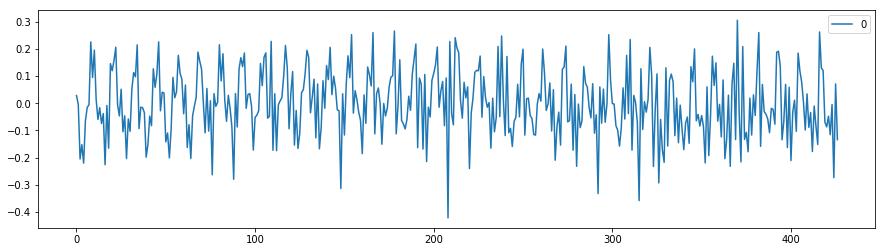

In [39]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(15,4))
plt.show()

In [40]:
residuals.head()

,0
0,0.028075
1,-0.004557
2,-0.204942
3,-0.152424
4,-0.220327


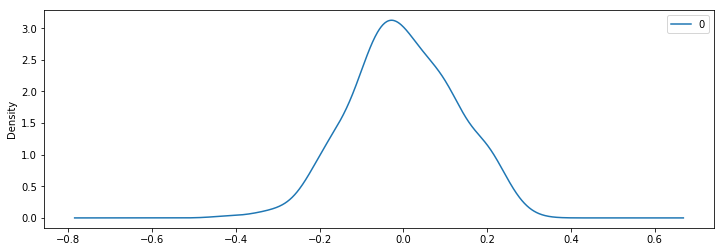

In [41]:
residuals.plot(kind='kde', figsize=(12,4))
plt.show()

In [42]:
from scipy import stats
print("KS P-value = "+str(round(stats.kstest(residuals, 'norm')[1], 10)))

KS P-value = 0.0


In [43]:
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model_1 = ARIMA(history, order=(0,1,2))
    model_fit_1 = model_1.fit(disp=0)
    output = model_fit_1.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error_ARIMA = mean_squared_error(test, predictions)**0.5
print('Test RMSE: %.3f' % error_ARIMA)

Test RMSE: 0.122


In [44]:
RollBack=pd.concat([pd.DataFrame({'TEST':test}),pd.DataFrame({'ARIMA':np.concatenate(predictions, axis=0)})],axis=1)
RollBack.head()

,TEST,ARIMA
0,4.927254,5.018557
1,5.247024,5.030858
2,5.257495,5.186171
3,5.257495,5.130449
4,4.990433,5.167606


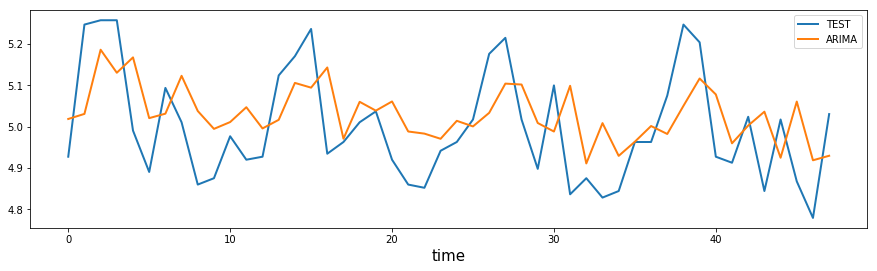

In [45]:
RollBack.plot(figsize=(15,4), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);

# Implementing SARIMAX

In [69]:
# from pmdarima import auto_arima
# stepwise_model = auto_arima(train,start_p=0,start_q=0,max_p=5,max_d=2,max_q=5,start_P=1,start_Q=1,max_P=2,max_D=2,max_Q=2,max_order=10,m=12,seasonal=True,trace=True,error_action='ignore',suppress_warnings=True,stepwise=True)
# print(stepwise_model.aic())

In [55]:
model = sm.tsa.statespace.SARIMAX(train, trend='n', order=(1,1,1), seasonal_order=(2,0,2,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  428
Model:             SARIMAX(1, 1, 1)x(2, 0, 2, 12)   Log Likelihood                 516.488
Date:                            Sat, 05 Sep 2020   AIC                          -1018.976
Time:                                    16:45:21   BIC                           -990.578
Sample:                                         0   HQIC                         -1007.759
                                            - 428                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1557      0.045     -3.473      0.001      -0.244      -0.068
ma.L1         -0.8856      0.024    -36.699      0.000      -0.933      -0.838
ar.S.L12       0.1025      0.131      0.780      0.435      -0.155       0.360
ar.S.L24       0.8918      0.130      6.847      0.000       0.637       1.147
ma.S.L12       0.0933      0.123      0.760      0.447      -0.147       0.334
ma.S.L24      -0.7999      0.098     -8.175      0.000      -0.992      -0.608
sigma2         0.0048      0.000     17.040      0.000       0.004       0.005
===================================================================================
Ljung-Box (Q):                      297.60   Jarque-Bera (JB):                27.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

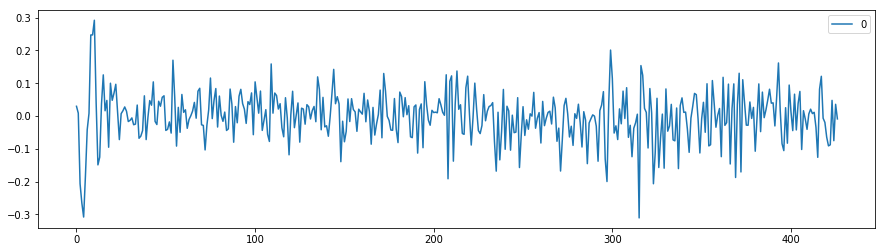

In [56]:
residuals1 = pd.DataFrame(results.resid[1:])
residuals1.plot(figsize=(15,4))
plt.show()

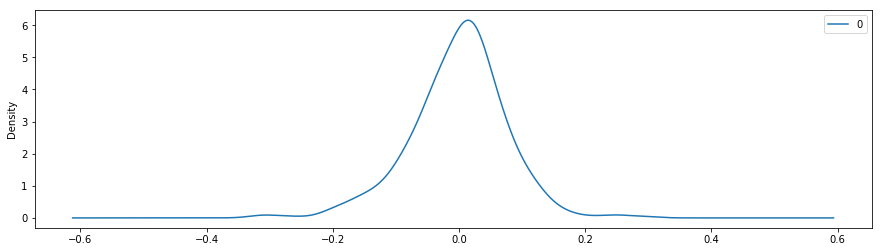

In [59]:
residuals1.plot(kind='kde', figsize=(15,4))
plt.show()

In [60]:
print("KS P-value = "+str(round(stats.kstest(residuals1, 'norm')[1], 10)))
print("D’Agostino and Pearson’s P-value = "+str(round(stats.normaltest(residuals1, axis=0)[1][0], 6)))

KS P-value = 0.0
D’Agostino and Pearson’s P-value = 0.0


In [63]:
X = df_log.values
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = sm.tsa.statespace.SARIMAX(history, trend='n', order=(1,1,1), seasonal_order=(2,0,2,12))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [64]:
error_SARIMA = mean_squared_error(test, predictions)**0.5
print('Test RMSE: %.3f' % error_SARIMA)

Test RMSE: 0.063


In [65]:
RollBack=pd.concat([RollBack,pd.DataFrame({'SARIMA':predictions})],axis=1)
RollBack.head()

,TEST,ARIMA,SARIMA
0,4.927254,5.018557,4.994034
1,5.247024,5.030858,5.182940
2,5.257495,5.186171,5.227065
3,5.257495,5.130449,5.303113
4,4.990433,5.167606,5.109420


Text(0.5,0,'time')

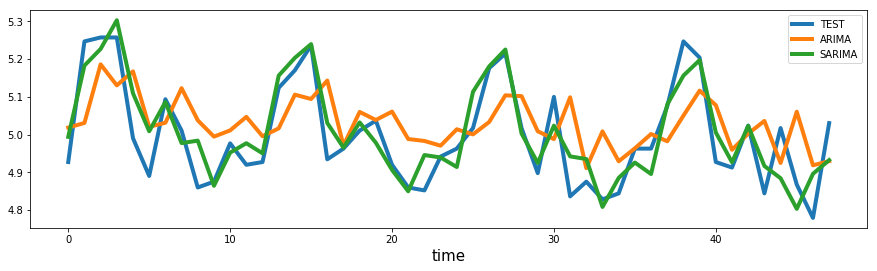

In [68]:
RollBack.plot(figsize=(15,4), linewidth=4, fontsize=10)
plt.xlabel('time', fontsize=15)

# Prophet Forecast

In [86]:
from fbprophet import  Prophet

In [71]:
data_pf = pd.DataFrame({'ds': df_log.index[:], 'y': df_log.values})
data_pf.head()

,ds,y
0,1956-01-01,4.534748
1,1956-02-01,4.564348
2,1956-03-01,4.555980
3,1956-04-01,4.345103
4,1956-05-01,4.261270


In [72]:
X = data_pf.y
Y = data_pf.ds
size = int(len(X) * 0.9)
train_X, test_X = X[0:size], X[size:len(X)]
train_Y, test_Y = Y[0:size], Y[size:len(Y)]
    
Train = pd.concat([train_Y,train_X], axis=1)
Test = pd.concat([test_Y,test_X], axis=1)

In [81]:
predictions = list()
    
def rolling_forecast():   
    history = Train.copy()
    
    for t in range(len(test_X)):
        m = Prophet()
        m.fit(history);
        future = m.make_future_dataframe(periods=1, freq='MS')
        forecast = m.predict(future)
        output=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        yhat = output[['yhat']][len(history):].values[0][0]
        predictions.append(yhat)
        obs = pd.DataFrame(Test[['ds','y']].iloc[t])
        history = pd.concat([history, obs.transpose()],axis=0)
        #print('predicted=%f, expected=%f' % (yhat, obs.transpose()['y']))

    
    error_PROPHET = mean_squared_error(test_X, predictions)**0.5
    print('Test RMSE: %.3f' % error_PROPHET)

In [82]:
import warnings
warnings.filterwarnings("ignore")
rolling_forecast()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Test RMSE: 0.078


In [83]:
error_PROPHET = mean_squared_error(test_X, predictions)**0.5
print('Test RMSE: %.3f' % error_PROPHET)

Test RMSE: 0.078


In [84]:
RollBack=pd.concat([RollBack,pd.DataFrame({'Prophet':predictions})],axis=1)
RollBack.head()

,TEST,ARIMA,SARIMA,Prophet
0,4.927254,5.018557,4.994034,5.037630
1,5.247024,5.030858,5.182940,5.183688
2,5.257495,5.186171,5.227065,5.223589
3,5.257495,5.130449,5.303113,5.309335
4,4.990433,5.167606,5.109420,5.109493


In [85]:
# Going forward we can implemen LSTM for the same time series and see if we are getting any good results. But for now the
# these results are pretty much good as we are getting RMSE very close to 0.